# Example optimisation with stochastic nonlocal modifications and gradient descent

## Imports

In [1]:
import seaborn as sns

In [2]:
from ship_routing.core import Route, WayPoint
from ship_routing.data import (
    load_currents,
    load_winds,
    load_waves,
)
from ship_routing.algorithms import (
    gradient_descent_across_track_left,
    gradient_descent_along_track,
    gradient_descent_time_shift,
    LargeIncrementError,
    InvalidGradientError,
    ZeroGradientsError,
    crossover_routes_minimal_cost,
    crossover_routes_random,
)

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
import tqdm
from random import choice
import xarray as xr
import shapely

## Parameters

In [4]:
np.random.seed(345)
population_size = 1_200

## Load and plot currents, winds, waves

In [5]:
currents = load_currents(
    data_file="data/currents/cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_2021-01_100W-020E_10N-65N.nc"
)
currents["speed"] = ((currents.to_array() ** 2).sum("variable") ** 0.5).where(
    ~currents.uo.isnull()
)

currents

<xarray.Dataset> Size: 10MB
Dimensions:  (lat: 661, lon: 1321, time: 1)
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float32 3kB 10.0 10.08 10.17 10.25 ... 64.75 64.83 64.92 65.0
  * lon      (lon) float32 5kB -100.0 -99.92 -99.83 -99.75 ... 9.833 9.917 10.0
  * time     (time) datetime64[ns] 8B 2021-01-01
Data variables:
    uo       (time, lat, lon) float32 3MB -0.1356 -0.1479 ... 0.07963 0.05846
    vo       (time, lat, lon) float32 3MB -0.01258 -0.02277 ... 0.2739 0.4073
    speed    (time, lat, lon) float32 3MB 0.1362 0.1497 0.163 ... 0.2852 0.4115
Attributes:
    Conventions:  CF-1.8
    area:         Global
    contact:      https://marine.copernicus.eu/contact
    credit:       E.U. Copernicus Marine Service Information (CMEMS)
    institution:  Mercator Ocean International
    licence:      http://marine.copernicus.eu/services-portfolio/service-comm...
    producer:     CMEMS - Global Monitoring and Forecasting Centre
    references:   http://marine.copernicus.eu
    source:       MOI GLO12
    title:        daily mean fields from Global Ocean Physics Analysis and Fo...

In [6]:
winds = load_winds(
    data_file="data/winds/cmems_obs-wind_glo_phy_my_l4_0.125deg_PT1H_2021-01_6hours_0.5deg_100W-020E_10N-65N.nc"
)
winds["speed"] = ((winds.to_array() ** 2).sum("variable") ** 0.5).where(
    ~winds.uw.isnull()
)
winds

<xarray.Dataset> Size: 26MB
Dimensions:  (time: 125, lat: 110, lon: 160)
Coordinates:
  * lat      (lat) float32 440B 10.06 10.56 11.06 11.56 ... 63.56 64.06 64.56
  * lon      (lon) float32 640B -99.94 -99.44 -98.94 ... -21.44 -20.94 -20.44
  * time     (time) datetime64[ns] 1kB 2021-01-01 ... 2021-02-01
Data variables:
    uw       (time, lat, lon) float32 9MB 1.77 2.06 1.19 ... -1.06 -0.82 -0.7
    vw       (time, lat, lon) float32 9MB -3.44 -3.66 -4.05 ... 0.15 0.1 -0.26
    speed    (time, lat, lon) float32 9MB 3.869 4.2 4.221 ... 0.8261 0.7467
Attributes: (12/26)
    Conventions:                CF-1.6, ACDD-1.3
    date_created:               2024-03-25T23:58:22
    date_modified:              2024-03-25T23:58:22
    geospatial_lat_max:         89.9375
    geospatial_lat_min:         -89.9375
    geospatial_lat_resolution:  0.125
    ...                         ...
    project:                    Copernicus Marine Service Wind Thematic Assem...
    references:                 Copernicus Marine Service Product User Manual...
    summary:                    Global ocean 10-m stress-equivalent wind and ...
    time_coverage_end:          2023-12-21T23:00:00
    time_coverage_start:        2023-12-21T23:00:00
    title:                       Global Ocean - Wind and Stress - Hourly - Re...

In [7]:
waves = load_waves(
    data_file="data/waves/cmems_mod_glo_wav_my_0.2deg_PT3H-i_VHM0_2021-01_1d-max_100W-020E_10N-65N.nc"
)

waves

<xarray.Dataset> Size: 14MB
Dimensions:  (lat: 276, lon: 401, time: 32)
Coordinates:
  * lat      (lat) float32 1kB 10.0 10.2 10.4 10.6 10.8 ... 64.4 64.6 64.8 65.0
  * lon      (lon) float32 2kB -100.0 -99.8 -99.6 -99.4 ... -20.4 -20.2 -20.0
  * time     (time) datetime64[ns] 256B 2001-01-01T12:00:00 ... 2001-02-01T12...
Data variables:
    wh       (time, lat, lon) float32 14MB ...

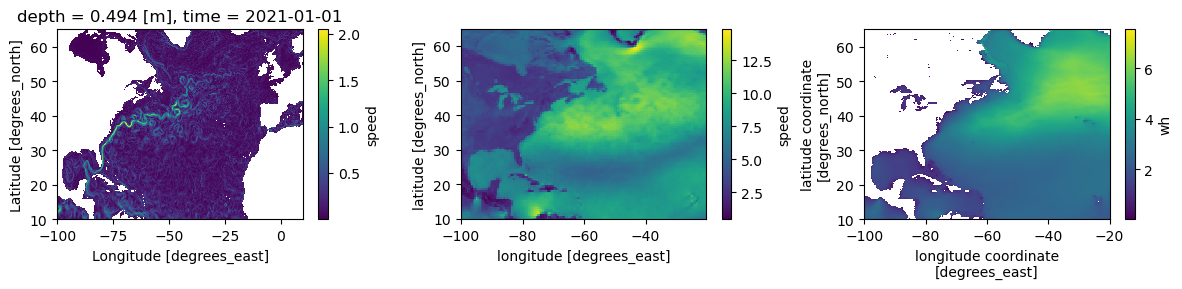

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

currents.speed.plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

fig.tight_layout();

## Define a route and have a look

Route departs close to the Gulf Stream and arrives close to Great Britain. This way, we may be able to surf the Gulf Stream for reducing fuel.

In [9]:
route_0 = Route(
    way_points=(
        WayPoint(lon=-80.5, lat=30, time=np.datetime64("2021-01-01")),
        WayPoint(lon=-25, lat=45, time=np.datetime64("2021-01-04")),
    )
)
# refine to 3 hourly way points
refine_to = np.mean([l.speed_ms for l in route_0.legs]) * 3 * 3600.0
route_0 = route_0.refine(distance_meters=refine_to)
route_0

Route(way_points=(WayPoint(lon=-80.5, lat=30, time=numpy.datetime64('2021-01-01')), WayPoint(lon=-78.68969695618517, lat=31.086742127247746, time=numpy.datetime64('2021-01-01T02:59:59.999')), WayPoint(lon=-76.83822880833705, lat=32.14730912624545, time=numpy.datetime64('2021-01-01T05:59:59.999')), WayPoint(lon=-74.94396975655307, lat=33.17999101970091, time=numpy.datetime64('2021-01-01T08:59:59.999')), WayPoint(lon=-73.00540106654056, lat=34.18300911191114, time=numpy.datetime64('2021-01-01T11:59:59.999')), WayPoint(lon=-71.02113998429357, lat=35.154517921716774, time=numpy.datetime64('2021-01-01T14:59:59.999')), WayPoint(lon=-68.98997205901848, lat=36.09260854850424, time=numpy.datetime64('2021-01-01T17:59:59.999')), WayPoint(lon=-66.91088670769119, lat=36.995313696971735, time=numpy.datetime64('2021-01-01T20:59:59.999')), WayPoint(lon=-64.78311566868122, lat=37.860614586725035, time=numpy.datetime64('2021-01-01T23:59:59.999')), WayPoint(lon=-62.60617376616913, lat=38.686449961712015,

In [10]:
print("speed (m/s)", np.mean([l.speed_ms for l in route_0.legs]))
print("speed (knots)", np.mean([l.speed_ms / 1.94 for l in route_0.legs]))

speed (m/s) 19.57356243489512
speed (knots) 10.08946517262635


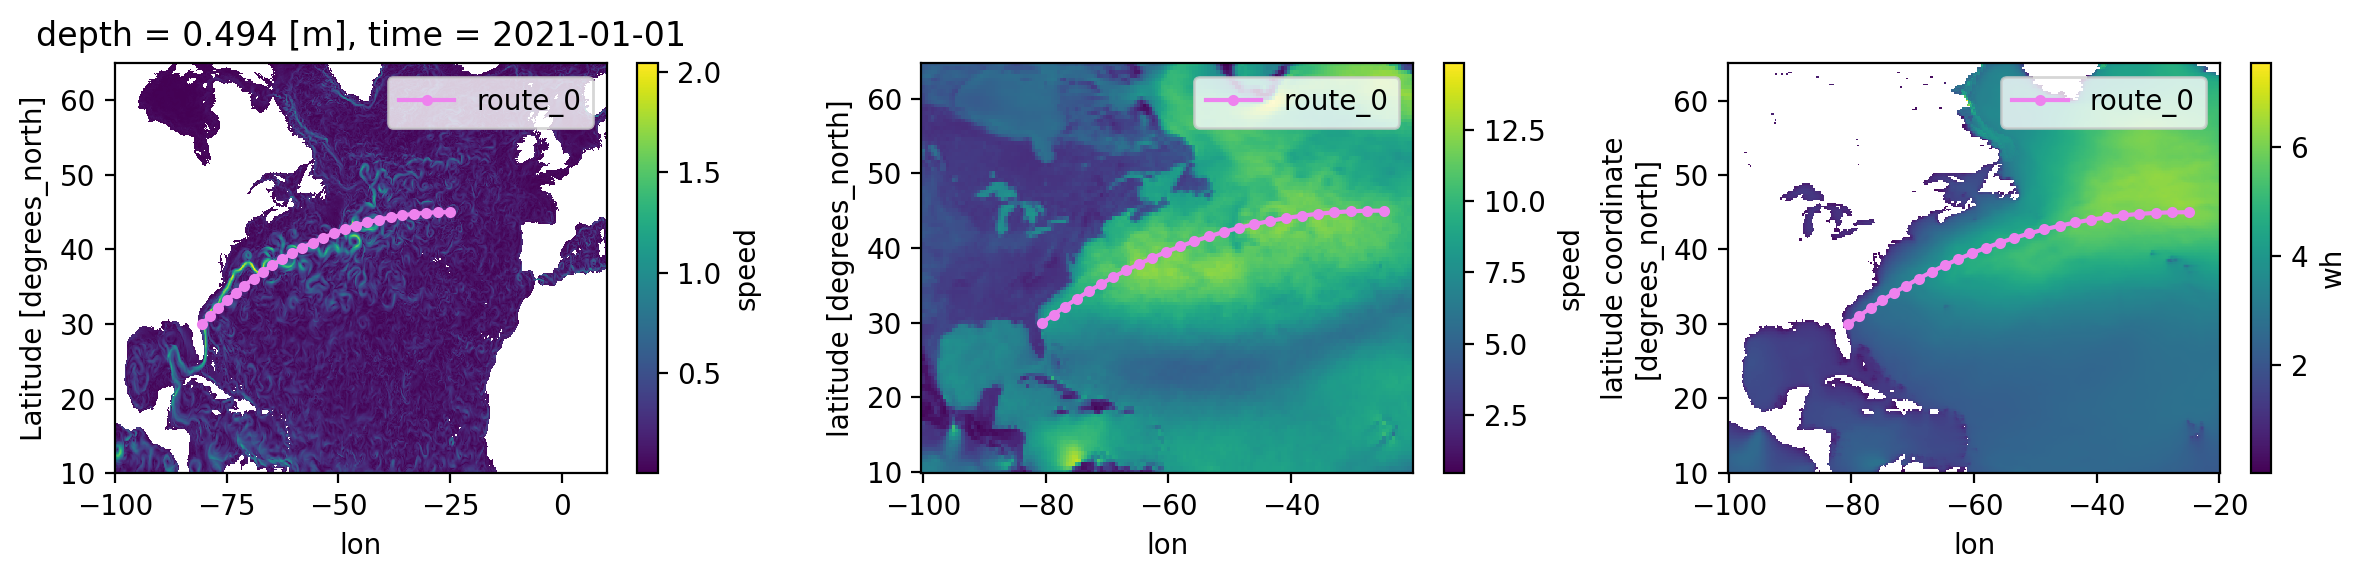

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

fig.set_dpi(200)

currents.speed.plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

for _ax in ax.flatten():
    route_0.data_frame.plot.line(
        x="lon", y="lat", marker=".", ax=_ax, color="violet", label="route_0"
    )

fig.tight_layout();

## Concurrency

In [12]:
from dask import delayed

In [13]:
@delayed
def route_cost_through(
    route: Route = None,
    current_data_set: xr.Dataset = None,
    wave_data_set: xr.Dataset = None,
    wind_data_set: xr.Dataset = None,
):
    return route.cost_through(
        current_data_set=current_data_set,
        wave_data_set=wave_data_set,
        wind_data_set=wind_data_set,
    )

In [14]:
@delayed
def route_mod_nonlocal_and_check_valid(
    route_cost: tuple = None,
    current_data_set: xr.Dataset = None,
    wave_data_set: xr.Dataset = None,
    wind_data_set: xr.Dataset = None,
    max_mod_width: float = None,
    max_mod_size: float = None,
):
    route = route_cost[0]
    cost = route_cost[1]

    if cost is None:
        cost = route.cost_through(
            current_data_set=current_data_set,
            wave_data_set=wave_data_set,
            wind_data_set=wind_data_set,
        )
    width_meters = np.random.uniform(max_mod_width / 2.0, max_mod_width)
    center_distance_meters = np.random.uniform(
        width_meters / 2.0, route.length_meters - width_meters / 2.0
    )
    max_move_meters = np.random.uniform(-max_mod_size, max_mod_size)
    _route = route.move_waypoints_left_nonlocal(
        center_distance_meters=center_distance_meters,
        width_meters=width_meters,
        max_move_meters=max_move_meters,
    )
    _cost = _route.cost_through(
        current_data_set=current_data_set,
        wave_data_set=wave_data_set,
        wind_data_set=wind_data_set,
    )
    if not np.isnan(_cost) and shapely.is_simple(_route.line_string) and _cost < cost:
        return _route, _cost
    else:
        return route, cost

In [15]:
@delayed
def delayed_crossover_routes_minimal_cost(
    route_cost_0: tuple = None,
    route_cost_1: tuple = None,
    current_data_set: xr.Dataset = None,
    wave_data_set: xr.Dataset = None,
    wind_data_set: xr.Dataset = None,
):
    try:
        return crossover_routes_minimal_cost(
            route_0=route_cost_0[0],
            route_1=route_cost_1[0],
            current_data_set=current_data_set,
            wave_data_set=wave_data_set,
            wind_data_set=wind_data_set,
        )
    except:
        # should never happen as we check for simplicity in the mutation step
        return route_cost_0[0]

In [16]:
_currents = currents.compute()
_winds = winds.compute()
_waves = waves.compute()

In [17]:
from dask.distributed import Client

In [18]:
client = Client(n_workers=12, threads_per_worker=1, memory_limit=2e9)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 12,Total memory: 22.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51227,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 22.35 GiB
Comm: tcp://127.0.0.1:51254,Total threads: 1
Dashboard: http://127.0.0.1:51258/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:51230,


2024-07-10 14:36:19,731 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:51278' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'delayed_crossover_routes_minimal_cost-214814cf-9bae-4962-8f51-34c3ab797a3f', 'delayed_crossover_routes_minimal_cost-d7dda697-5ef4-4d42-95ab-0cc829c50977', 'delayed_crossover_routes_minimal_cost-32108799-8bfc-469d-85e1-26fa63e87e74', 'delayed_crossover_routes_minimal_cost-fcc43bd4-4226-4a3d-b05b-e5fda30798d5', 'delayed_crossover_routes_minimal_cost-8328861d-6d4a-40b9-866f-198d8c2337d1', 'delayed_crossover_routes_minimal_cost-9c3c0c6c-b683-489a-9859-fcd180a2bc25', 'delayed_crossover_routes_minimal_cost-90a9eda8-acc4-409b-a7b4-c4ff3b974bdc', 'delayed_crossover_routes_minimal_cost-7fd818cd-d62d-4c02-acbf-35d3cd7781ce', 'delayed_crossover_routes_minimal_cost-51af5be1-01b4-4eda-9367-b46e4940620c', 'delayed_crossover_routes_minimal_cost-9ea1ecd2-b609-4b06-942a-c2b1ca47864b', 'delayed_crossover_routes_mini

In [19]:
currents = client.scatter(currents, broadcast=True)
winds = client.scatter(winds, broadcast=True)
waves = client.scatter(waves, broadcast=True)

In [20]:
cost_0 = route_0.cost_through(
    current_data_set=_currents,
    wind_data_set=_winds,
    wave_data_set=_waves,
)

In [21]:
routes_costs = [
    route_mod_nonlocal_and_check_valid(
        route_cost=(route_0, cost_0),
        current_data_set=currents,
        wind_data_set=winds,
        wave_data_set=waves,
        max_mod_size=route_0.length_meters / 2.0,
        max_mod_width=route_0.length_meters / 4.0,
    )
    for rc in range(population_size)
]

In [22]:
routes_costs = [
    route_mod_nonlocal_and_check_valid(
        route_cost=rc,
        current_data_set=currents,
        wind_data_set=winds,
        wave_data_set=waves,
        max_mod_size=route_0.length_meters / 2.0,
        max_mod_width=route_0.length_meters / 4.0,
    )
    for rc in routes_costs
]

In [23]:
routes_costs = [
    route_mod_nonlocal_and_check_valid(
        route_cost=rc,
        current_data_set=currents,
        wind_data_set=winds,
        wave_data_set=waves,
        max_mod_size=route_0.length_meters / 2.0,
        max_mod_width=route_0.length_meters / 4.0,
    )
    for rc in routes_costs
]

In [24]:
routes_crossed = [
    delayed_crossover_routes_minimal_cost(
        route_cost_0=routes_costs[np.random.randint(population_size)],
        route_cost_1=routes_costs[np.random.randint(population_size)],
        current_data_set=currents,
        wave_data_set=waves,
        wind_data_set=winds,
    )
    for n in range(population_size)
]

In [25]:
%%time

routes_crossed = [rc.persist() for rc in routes_crossed]

cost_crossed = [
    route_cost_through(
        route=r,
        current_data_set=currents,
        wave_data_set=waves,
        wind_data_set=winds,
    )
    for r in routes_crossed
]
cost_crossed = [c.persist() for c in cost_crossed]
cost_crossed = [c.compute() for c in cost_crossed]

/Users/wrath/micromamba/envs/ship_routing/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/wrath/micromamba/envs/ship_routing/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/wrath/micromamba/envs/ship_routing/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/wrath/micromamba/envs/ship_routing/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/wrath/micromamba/envs/ship_routing/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, 

CPU times: user 2min 27s, sys: 28.1 s, total: 2min 55s
Wall time: 9min 18s


In [26]:
cc = pd.Series(cost_crossed)
# cc = cc.where(cc < cost_0)
cc

0       5.938090e+13
1       5.938090e+13
2       5.938090e+13
3       5.934394e+13
4       5.938090e+13
            ...     
1195    5.922424e+13
1196    5.938090e+13
1197    5.938090e+13
1198    5.938090e+13
1199    5.938090e+13
Length: 1200, dtype: float64

<Axes: ylabel='Frequency'>

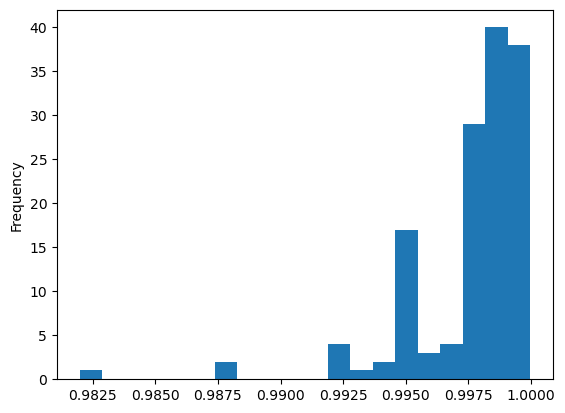

In [27]:
(cc.where(cc < cost_0) / cost_0).plot.hist(bins=20)

In [28]:
(cc < cost_0).mean()

0.1175

In [29]:
cc.argmin()

50

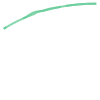

In [30]:
shapely.union(
    routes_crossed[cc.argmin()].compute().line_string,
    routes_crossed[cc.argmax()].compute().line_string,
)

In [31]:
cc.min() / cost_0

0.9819740797788795

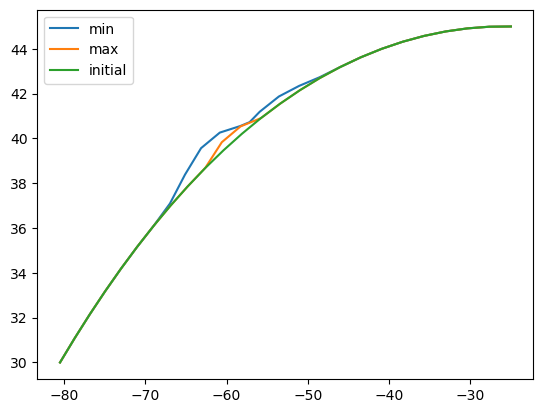

In [32]:
plt.plot(*routes_crossed[cc.argmin()].compute().line_string.xy, label="min")
plt.plot(*routes_crossed[cc.argmax()].compute().line_string.xy, label="max")
plt.plot(*route_0.line_string.xy, label="initial")
plt.legend()

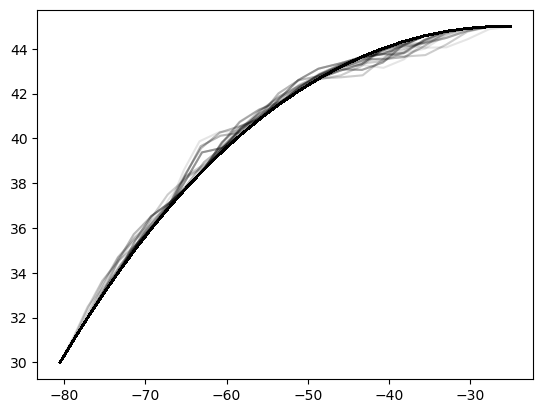

In [34]:
for r in routes_crossed:
    plt.plot(*r.compute().line_string.xy, "k-", alpha=0.1);